In [90]:
from hmc_base import *
from hmc_unconstrained import *
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta

# Import data from LearnBayes package

In [70]:
# get data pair list
file = open("cancermortality.txt", "r") 
data = (file.read()) 
tmp = data.split()
tmp = tmp[2:len(tmp)]
tmp = [int(e) for e in tmp]
data_list = []
for i in range(0, int(len(tmp)-1), 2):
    data_list.append([tmp[i], tmp[i+1]])

In [110]:
# get death number list
death = []
for i in range(len(data_list)):
    death.append(data_list[i][0])
# convert to np array
death = np.array(death)

# get risk number list
risk = []
for i in range(len(data_list)):
    risk.append(data_list[i][1])
# convert to np array
risk = np.array(risk)

# Posterior distribution for position x

In [198]:
# define posterior probability function for the beta-binomial distribution 
def posterior(y, n, eta, k):
    t1 = 1/(eta*(1-eta))
    t2 = 1/np.power((1+k), 2)
    t3 = np.prod(beta(k*eta+y, k*(1-eta)+n-y)/beta(k*eta, k*(1-eta)))
    final = t1*t2*t3
    return final
    
def log_posterior(y, n, eta, k):
    t1 = 0-np.log(eta)-np.log(1-eta)
    t2 = 0-2*np.log(1+k)
    t3 = np.log(beta(k*eta+y, k*(1-eta)+n-y))-np.log(beta(k*eta, k*(1-eta)))
    t3 = np.sum(t3)
    final = t1+t2+t3
    return final

In [199]:
log_posterior(death, risk, 0.01, 1000)

-658.08077990418951

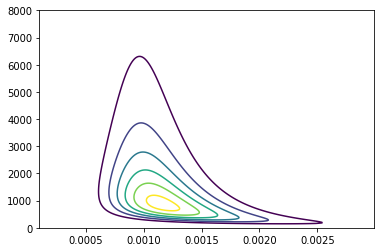

In [204]:
# create grid and contour values
x = np.arange(0.0001, 0.003, 0.00001)
y = np.arange(1, 20000, 20)
X, Y = np.meshgrid(x, y)
xrange = X.shape[1]
yrange = X.shape[0]
Z = np.zeros([yrange, xrange])
for i in range(xrange):
    for j in range(yrange):
        Z[j][i] = posterior(death, risk, X[j][i], Y[j][i])
# plot
plt.figure()
plt.ylim([0, 8000])
CS = plt.contour(X, Y, Z)

# 

In [9]:
def gaussian(x, mu, sig):
    #return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu), 2.)/(2 * np.power(sig, 2.))) 

In [10]:
def gaussian_energy(x, mu, sig):
    gaus = gaussian(x, mu, sig)
    return -np.log(gaus)


In [11]:
def unit_gaussian_energy(x, cache):
    gaus = gaussian(x, 0, 1)
    return -np.log(gaus)

In [12]:
gaussian_energy(0,0,1)

0.91893853320467267

In [13]:
sampler = IsotropicHmcSampler(unit_gaussian_energy, energy_grad=None, prng=None,
                 mom_resample_coeff=1., dtype=np.float64)

In [77]:
pos_samples, mom_samples, ratio = sampler.get_samples(np.array([5]), 0.1, 10, 1000)

In [80]:
pos = pos_samples.ravel()

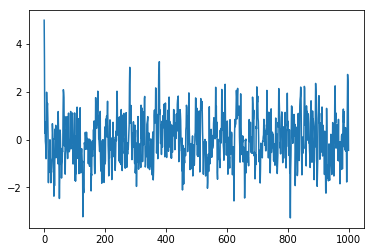

In [79]:
plt.plot(pos)

In [82]:
for i in range(8):
    def test(x):
        return x+i
    print(test(i))

0
2
4
6
8
10
12
14
